# Exploratory Data Analysis
In this notebook the data will be inspected with graphical and statistical methods to identify e.g. outliers, trends, correlations, ... .

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from IPython.display import display
from scipy.stats import chisquare

%matplotlib inline

## Load data

In [2]:
cnx = sqlite3.connect('../data/data2.db')
cursor = cnx.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())
cnx.close()

[('data',), ('error',), ('extra',), ('data_clean',), ('error_clean',), ('data_error',)]


In [2]:
df_combo= pd.read_sql('SELECT * FROM data_error','sqlite:///../data/data2.db',index_col='index')
df_combo.head()

,id_013,xx_006,cl_002,cl_004,flg_000,id_000,ty_000,cl_000,xx_000,id_001,...,id_026,flg_001,xx_026,dt_001,xx_027,xx_028,xx_029,ty_006,id_033,error
index,,,,,,,,,,,,,,,,,,,,,
0,id_013_unknown,999.0,cl_002_unknown,cl_004_unknown,flg_000_unknown,372892,ty_000_other,cl_000_001,xx_000_5,id_001_unknown,...,id_026_unknown,flg_001_0,64,2020-04-09 06:01:09,xx_027_002,0,xx_029_000,ty_006_000,1041973,0
1,id_013_unknown,999.0,cl_002_unknown,cl_004_unknown,flg_000_unknown,372893,ty_000_other,cl_000_000,xx_000_5,id_001_unknown,...,id_026_unknown,flg_001_0,41,2020-04-09 06:01:39,xx_027_001,0,xx_029_000,ty_006_000,1041974,0
2,id_013_unknown,999.0,cl_002_unknown,cl_004_unknown,flg_000_unknown,372894,ty_000_other,cl_000_000,xx_000_5,id_001_unknown,...,id_026_unknown,flg_001_0,44,2020-04-09 06:01:39,xx_027_001,0,xx_029_000,ty_006_000,1041975,0
3,id_013_unknown,999.0,cl_002_unknown,cl_004_unknown,flg_000_unknown,372893,ty_000_other,cl_000_000,xx_000_20,id_001_unknown,...,id_026_unknown,flg_001_0,50,2020-04-09 06:01:39,xx_027_001,2,xx_029_001,ty_006_001,1041976,0
4,id_013_unknown,999.0,cl_002_unknown,cl_004_unknown,flg_000_unknown,372894,ty_000_other,cl_000_000,xx_000_20,id_001_unknown,...,id_026_unknown,flg_001_0,53,2020-04-09 06:01:39,xx_027_001,2,xx_029_001,ty_006_001,1041977,0


### Comment
*_unknown* and *_other* can be two different categories, but if *_unknown* is not given *_other* might contain the unknown entries, or there are no unknown entries for this feature.

In [26]:
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39047 entries, 0 to 39168
Data columns (total 41 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_013   39047 non-null  object 
 1   xx_006   39047 non-null  float64
 2   cl_002   39047 non-null  object 
 3   cl_004   39047 non-null  object 
 4   flg_000  39047 non-null  object 
 5   id_000   39047 non-null  int64  
 6   ty_000   39047 non-null  object 
 7   cl_000   39047 non-null  object 
 8   xx_000   39047 non-null  object 
 9   id_001   39047 non-null  object 
 10  xx_001   39047 non-null  object 
 11  cl_001   39047 non-null  object 
 12  id_002   39047 non-null  object 
 13  id_003   39047 non-null  object 
 14  id_004   39047 non-null  object 
 15  id_005   39047 non-null  object 
 16  id_006   39047 non-null  object 
 17  id_007   39047 non-null  object 
 18  id_008   39047 non-null  object 
 19  xx_005   39047 non-null  object 
 20  ty_002   39047 non-null  object 
 21  ty_004   390

## First data exploration

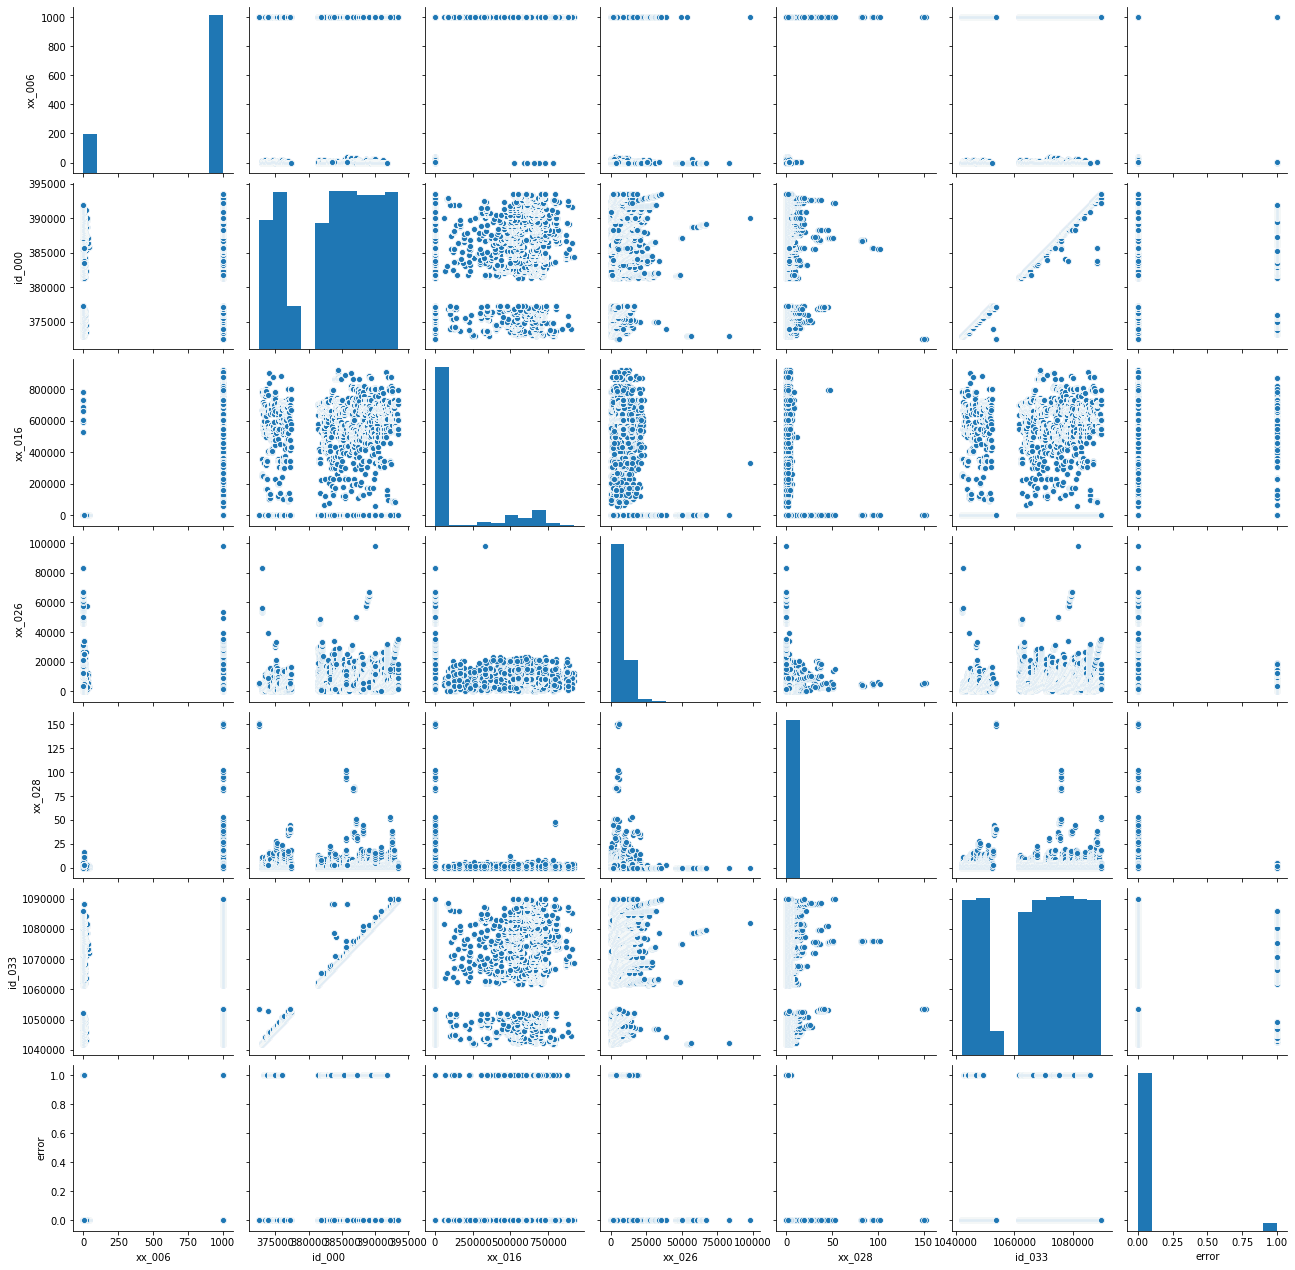

In [27]:
sns.pairplot(df_combo)

**First observation** from this plot is that errors do not correlate to high values of **xx_026** and **xx_028**.

### Create clusters for xx_006, xx_016 and xx_28
We have inside knowledge that these features contain numerical data and to compare it to the other features, clusters are defined.

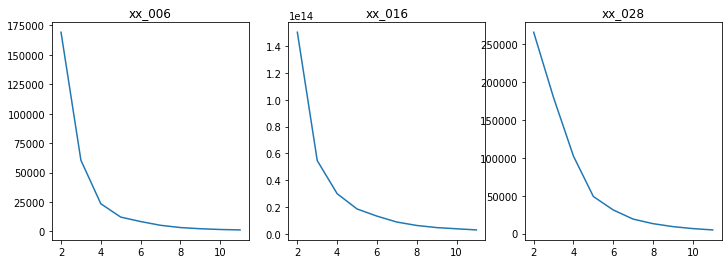

In [3]:
from sklearn.cluster import KMeans
plt.figure(figsize=(12,4))
k = 1
for var in ['xx_006','xx_016','xx_028']:
    inertia = []

    for nc in range(2,12):
        kmeans = KMeans(n_clusters=nc)
        kmeans.fit(df_combo[var].values.reshape(-1,1))
        inertia.append(kmeans.inertia_)  
    plt.subplot(1,3,k)
    plt.plot(range(2,12),inertia)
    plt.title(var)
    k+=1
    

In [4]:
for var in ['xx_006','xx_016','xx_028']:
    if var == 'xx_028':
        n_clust = 5
    else:
        n_clust = 4
    # Generate new cluster
    kmeans = KMeans(n_clusters=n_clust)
    df_temp = pd.DataFrame(df_combo[var].copy())
    df_temp[var+'_cluster'] = kmeans.fit_predict(df_combo[var].values.reshape(-1,1))
    # analyze cluster
    tab = df_temp.groupby(var+'_cluster').agg({var:['mean','min','max','std']})
    #print(tab)
    # sort cluster
    new_clust = np.argsort(tab[var].loc[:,'min'])
    temp = np.zeros(len(df_temp[var+'_cluster']),dtype=int)
    for i in range(len(new_clust)):
        #print(i,new_clust[i])
        temp[df_temp[var+'_cluster']==new_clust[i]]=i
    df_temp.loc[:,var+'_cluster'] = temp
    print(df_temp.groupby(var+'_cluster').agg({var:['mean','min','max','std']}))
    # Create dummy features
    df_temp2 = pd.get_dummies(df_temp[var+'_cluster'],prefix=var, prefix_sep='_')
    # Add to data set
    df_combo = pd.concat([df_combo.drop(var,axis=1),df_temp2],axis=1)

                    xx_006                        
                      mean    min    max       std
xx_006_cluster                                    
0                 0.594083    0.0    3.0  0.889692
1                 7.289790    4.0   18.0  3.357280
2                28.813433   20.0   40.0  5.500742
3               999.000000  999.0  999.0  0.000000
                       xx_016                              
                         mean     min     max           std
xx_016_cluster                                             
0                  935.533815       0  170000  11220.866766
1               346677.467105  179700  437600  61848.089901
2               538566.912610  447000  618200  46043.352644
3               704526.062992  621800  921528  59939.416659
                    xx_028                    
                      mean min  max        std
xx_028_cluster                                
0                 0.006042   0    1   0.077498
1                 2.544010   2    6

### Drop xx_026

Inside information has shown that **xx_026** is actually of type identifier. Due to the fact that it is neither unique nor easy to categorize, it is dropped from the data set.

In [5]:
df_combo.drop('xx_026', axis=1, inplace=True)

## Make dt a datetime object

In [6]:
x = 'dt_001'
df_combo[x] = pd.to_datetime(df_combo[x])
df_combo.loc[:,x] = df_combo[x].apply(lambda y: y.replace(microsecond=0))


## Create dummy features

In [7]:
df_analysis = pd.DataFrame(df_combo.nunique(),columns=['nunique'])
no1 = []
count1 = []
no2 = []
count2 = []

for v in df_combo.columns:
    no1.append(df_combo[v].value_counts().index[0])
    count1.append(df_combo[v].value_counts().iloc[0])
    no2.append(df_combo[v].value_counts().index[1])
    count2.append(df_combo[v].value_counts().iloc[1])
df_analysis['no1'] = no1
df_analysis['count1'] = count1
df_analysis['no2'] = no2
df_analysis['count2'] = count2

df_analysis

,nunique,no1,count1,no2,count2
id_013,205,id_013_unknown,34632,190050,136
cl_002,2,cl_002_unknown,31395,cl_002_000,7652
cl_004,2,cl_004_unknown,32909,cl_004_other,6138
flg_000,2,flg_000_unknown,31395,flg_000_other,7652
id_000,16651,382961,6,381754,6
ty_000,7,ty_000_000,8370,ty_000_001,7824
cl_000,2,cl_000_000,28087,cl_000_001,10960
xx_000,3,xx_000_5,19329,xx_000_20,13839
id_001,2844,id_001_unknown,1704,id_001_000,1194
xx_001,2,xx_001_000,28058,xx_001_unknown,10989


We can see that there are categories whose most frequent value is *unknown*. Additionally, **id_000** and **id_033** are either unique or not frequent enough. Since they are simple identifiers and don't carry a quantitaive value, they will be dropped now.

In [8]:
df_combo.drop(['id_000','id_033'],inplace= True, axis=1)

Now we can finally create dummy features.

In [9]:
df_dum = df_combo.copy()
for var in df_dum.columns:
    if (df_dum[var].nunique() <=10):
        if type(df_dum[var].unique()[0])==str:
            if ('1' in df_dum[var].unique())|('0.0' in df_dum[var].unique())|(('0' in df_dum[var].unique())):
                print(var, ' has integers as strings')
                continue
            df_temp = pd.get_dummies(df_combo[var])
            df_dum = pd.concat([df_dum.drop(var,axis=1),df_temp],axis=1)
            del df_temp
        else:
            print('Integer values: ',var,' ::: ',df_dum[var].unique())
    else:
        print('Too many different values: ' ,var,' ::: ',len(df_dum[var].unique()))
df_dum.info()

Too many different values:  id_013  :::  205
Too many different values:  id_001  :::  2844
Too many different values:  id_004  :::  846
Too many different values:  id_006  :::  683
Too many different values:  id_008  :::  638
Too many different values:  id_026  :::  2584
Too many different values:  dt_001  :::  10673
Integer values:  error  :::  [0 1]
Integer values:  xx_006_0  :::  [0 1]
Integer values:  xx_006_1  :::  [0 1]
Integer values:  xx_006_2  :::  [0 1]
Integer values:  xx_006_3  :::  [1 0]
Integer values:  xx_016_0  :::  [1 0]
Integer values:  xx_016_1  :::  [0 1]
Integer values:  xx_016_2  :::  [0 1]
Integer values:  xx_016_3  :::  [0 1]
Integer values:  xx_028_0  :::  [1 0]
Integer values:  xx_028_1  :::  [0 1]
Integer values:  xx_028_2  :::  [0 1]
Integer values:  xx_028_3  :::  [0 1]
Integer values:  xx_028_4  :::  [0 1]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 39047 entries, 0 to 39168
Columns: 108 entries, id_013 to ty_006_other
dtypes: datetime64[ns](1), int6

# Calculate chi-square

In [36]:
def calc_chi2(df,col1,col2,print_mat=False):
    tab = pd.crosstab(df[col1],df[col2])
    f_exp = tab.copy()
    total = sum(tab.iloc[0,:])+sum(tab.iloc[1,:])
    for k in range(f_exp.shape[0]):
        for l in range(f_exp.shape[1]):
            f_exp.iloc[k,l] = (sum(tab.iloc[k,:])*sum(tab.iloc[:,l]))/total
    chi2 = tab.copy()
    for k in range(f_exp.shape[0]):
        for l in range(f_exp.shape[1]):
            chi2.iloc[k,l] = (tab.iloc[k,l]-f_exp.iloc[k,l])**2/f_exp.iloc[k,l]
    if print_mat:
        print('Observed:')
        display(tab) #
        print('Expected:')
        display(f_exp)
        print('Chi2:')
        display(chi2)
    print('chi2 = ',sum(chi2.sum(axis=0)))
    return chi2;

The chi-square value is calculated as follows:

$c^2= \sum_{i,j} \frac{(f_{o}(i,j) - f_{e}(i,j))^2}{f_{e}(i,j)}$

where $f_{o/e}(i,j)$ is the observed/expected frequency of feature $i$ in reference to feature $j$. The expected frequency is calculated as:

$f_e(i,j) = \frac{\sum_{i^*} f_o(i^*,j) \cdot \sum_{j^*} f_o(i,j^*)}{\sum_{i^*,j^*}f_o(i^*,j^*)}$

For example: For coty_EURO == 1 the observed frequency is 21415 for heightcl == 1. The expected frequency is (21413+8384)(450+21413)/(8384+21413+8317+450) = 16892.74 . This means that coty_EURO == 1 is observed more often for heightcl == 1 than expected. The chi-square value will tell us if the overall distribution shows a significantly different distribution than expected:

$chi^2 = 1209.555$ which is clearly above the critical $\chi^2 = 3.841$ for a significance of 0.05. The p-value is 0.0014.

In [38]:
chi2 = calc_chi2(df_dum,'cl_001_000','xx_005_00',print_mat=True)

Observed:


xx_005_00,0,1
cl_001_000,,
0,13482,7191
1,2400,15974


Expected:


xx_005_00,0,1
cl_001_000,,
0,8408.548314,12264.451686
1,7473.451686,10900.548314


Chi2:


xx_005_00,0,1
cl_001_000,,
0,3061.160031,2098.741360
1,3444.179891,2361.341033


chi2 =  10965.422314924495


### Conditions for chi-squared test

1) simple random sampling (representative)

2) categorical data

3) at least 5 counts per level and feature

So we need to filter the features and levels that do not meet these criteria, especially the third.

In [39]:
print('Our data set is very imbalanced with only ',round(sum(df_dum.error)/len(df_dum.error)*100,2),'% of data being errors.')

Our data set is very imbalanced with only  4.83 % of data being errors.


## Do the chi-squared test for the errors

We have a data frame with dummy features which can be grouped by their original feature. The number of subfeatures also determines the degree of freedom, which is crucial for the critical chi squared value.

In [62]:
from scipy.stats import chisquare
cols = df_dum.drop('error',axis=1).columns
crit_val = 5
tot_cols = len(cols)
dic = {}
i = 0
while i < tot_cols:
    # identify the range of columns that belong to this (sub)feature
    j = i+1
    v1 = cols[i].split('_')[0]
    if (len(cols[i].split('_'))>2) & (j < tot_cols):
        var = v1+'_'+cols[i].split('_')[1]
        while var in cols[j]:
            j += 1
            if (j == tot_cols):
                break
    else:
        var = cols[i]
        print('{} has no subfeatures, invalid for chi square'.format(var))
        i=j
        continue
    # Determine error frequencies
    tab = df_dum.groupby('error').sum().loc[:,cols[i:j]]
    
    # Calculate expected frequencies for an equal distribution (null hypothesis)
    f_exp = np.array(tab.copy(),dtype=float)
    total = sum(tab.sum(axis=1))
    for k in range(f_exp.shape[0]):
        for l in range(f_exp.shape[1]):
            f_exp[k][l] = (sum(tab.iloc[k,:])*sum(tab.iloc[:,l]))/total
            if f_exp[k][l] == 0.:
                print(cols[i],k,l)
    # Calculate chi-square and p-values for this feature set
    chi = chisquare(tab,f_exp=f_exp)
    dic_t = {'chi':sum(chi.statistic)}
    dic_t['p'] = max(chi.pvalue)
    dic_t['df'] = j-i-1
    if sum(sum((tab<crit_val).values))>0:
        dic_t['critical'] = True
    else:
        dic_t['critical'] = False
    dic[var] = dic_t
    i = j
    del chi, dic_t

id_013 has no subfeatures, invalid for chi square
id_001 has no subfeatures, invalid for chi square
id_004 has no subfeatures, invalid for chi square
id_006 has no subfeatures, invalid for chi square
id_008 has no subfeatures, invalid for chi square
id_026 has no subfeatures, invalid for chi square
dt_001 has no subfeatures, invalid for chi square


In [41]:
class bcolors:
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[31m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'

In [64]:
# Define critical chi squared value for a p-value of 0.05
crit_chisquare = [0,3.84,5.99,7.81,9.49,11.07,12.59,14.07,15.51]
for k in dic.keys():
    if dic[k]['df'] == 0:
        print(bcolors.OKBLUE+'{} has no subfeatures'.format(k)+bcolors.ENDC)
    elif dic[k]['critical']:
        print(bcolors.WARNING+bcolors.BOLD+'{} is below critical frequency.'.format(k)+bcolors.ENDC)
    elif dic[k]['p'] > 0.05:
        print(bcolors.WARNING+bcolors.BOLD+'{} is not significant'.format(k)+bcolors.ENDC)
    elif dic[k]['chi']<= crit_chisquare[dic[k]['df']]:
        print(bcolors.WARNING+bcolors.BOLD+'{} is below critical value'.format(k)+bcolors.ENDC)
    else:
        print(bcolors.OKGREEN+bcolors.BOLD+'{} is significant'.format(k)+bcolors.ENDC)

xx_006 is below critical frequency.
xx_016 is significant
xx_028 is below critical frequency.
cl_002 is significant
cl_004 is below critical frequency.
flg_000 is significant
ty_000 is below critical frequency.
cl_000 is significant
xx_000 is below critical frequency.
xx_001 is significant
cl_001 is significant
id_002 is significant
id_003 is below critical frequency.
id_005 is below critical frequency.
id_007 is below critical frequency.
xx_005 is significant
ty_002 is below critical frequency.
ty_004 is significant
cl_003 is significant
id_018 is below critical frequency.
id_019 is below critical frequency.
xx_014 is significant
cl_006 is significant
cl_007 is significant
cl_008 is significant
id_024 is significant
flg_001 is significant
xx_027 is below critical frequency.
xx_029 is significant
ty_006 is significant


### Investigate why some features are not significant

In [44]:
var = 'xx_000'
df_chi2 = df_dum.copy()
cols = df_chi2.drop('error',axis=1).columns
tot_cols = len(cols)
i = 0
while var not in cols[i]:
    i+=1
j = i+1
while var in cols[j]:
    j += 1
    if (j == tot_cols):
        break
tab = df_chi2.groupby('error').sum().loc[:,cols[i:j]]
print(tab)
bla = np.where(tab<new_lim)
if len(bla[0])>= 1:
    print('With the frequency limit of ',new_lim,' these columns are removed: ',tab.columns[bla[1]][:])
    tab.drop(tab.columns[bla[1]],inplace=True, axis=1)
f_exp = np.array(tab.copy(),dtype=float)
total = sum(tab.sum(axis=1))
for k in range(f_exp.shape[0]):
    for l in range(f_exp.shape[1]):
        f_exp[k][l] = (sum(tab.iloc[k,:])*sum(tab.iloc[:,l]))/total
        if f_exp[k][l] == 0.:
            print(cols[i],k,l)
chi = chisquare(tab,f_exp=f_exp)
df = j-i-1-len(bla[0])
print('chi: ',sum(chi.statistic))
print('p: ',max(chi.pvalue))
print('df: ',df)
print('crit chi2:', crit_chisquare[df])

       xx_000_20  xx_000_5  xx_000_other
error                                   
0        12912.0   18373.0        5876.0
1          927.0     956.0           3.0
With the frequency limit of  10  these columns are removed:  Index(['xx_000_other'], dtype='object')
chi:  46.2567592316714
p:  1.1169772287565977e-05
df:  1
crit chi2: 3.84


## Conclusion about chi squared test

The test can only be applied to features that have **subfeatures** and **frequencies > 5**. The above analysis has shown that:

- The data set is quite imbalanced with only 5% of data being an error (which in practice is good)
- Not all features and subfeatures are qualified for the chi square test.
- Of the 30 qualified features, 12 features are not significant as provided and according to the chi-squared test.
- Further inspection of the *insignificant* features has shown that this could be related to the grouping of values. Also, choosing a higher cut-off value could change the results for the other features too.

Remaining open questions:

- How should the cut-off value be chosen?
- What should be done with subfeatures that have a low error frequency?
- What other statistical tests should be applied?

## Plot the distribution of data

/home/lhw/DSproject/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/home/lhw/DSproject/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/home/lhw/DSproject/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes 

[24]


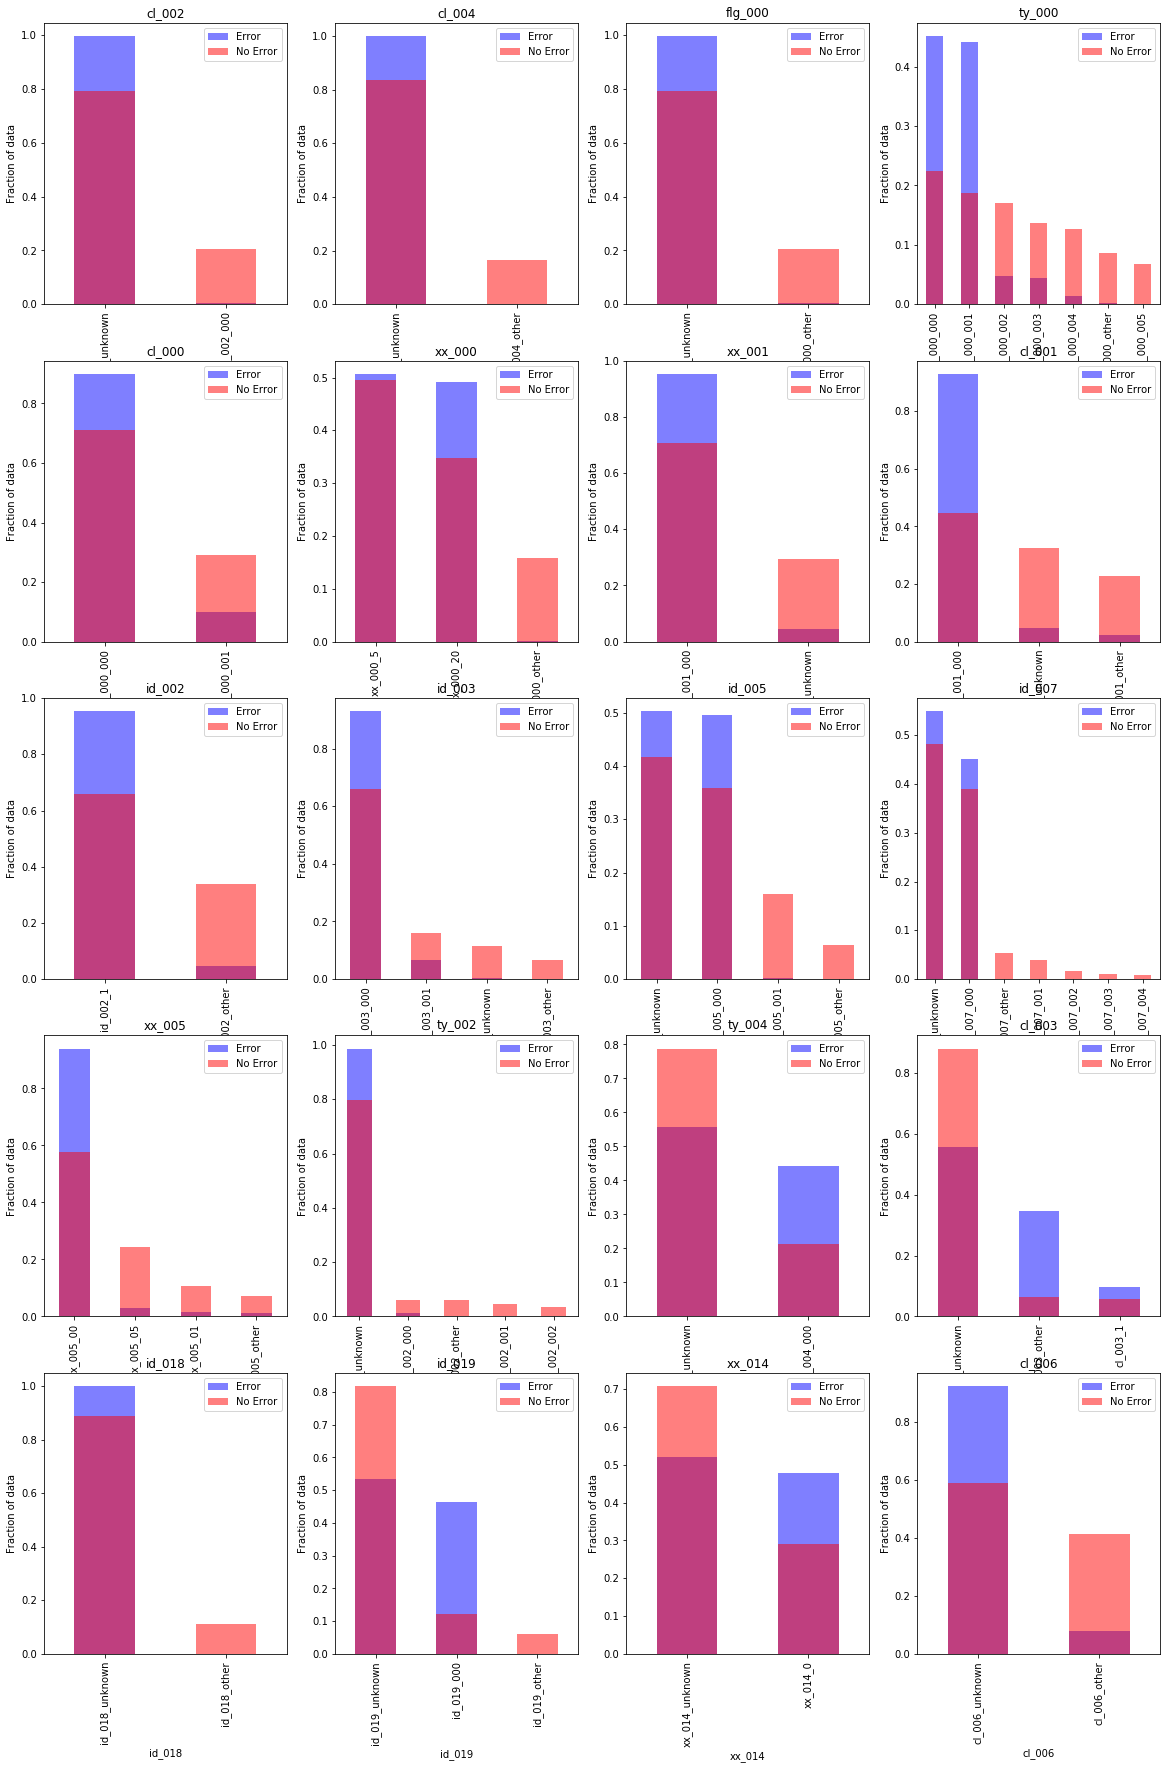

In [126]:
k=1
plt.figure(figsize=(20,30))
for v in df_combo.columns:
    plt.subplot(5,4,k)
    if len(df_combo[v].unique())>10:
        continue
    tab =df_combo.groupby('error')[v].value_counts(normalize=True)
    tab[1].plot(kind='bar', alpha=0.5,color='blue',label='Error')
    tab[0].plot(kind='bar', alpha=0.5,color='r',label='No Error')
    plt.legend()
    plt.ylabel('Fraction of data')
    plt.title(v)
    k+=1
    if k == 21:
        print(np.where(df_combo.columns==v)[0])
        break
plt.show()

For almost all except for **ty_004**, **cl_003**, **id_019** and **xx_014** the distribution for the error is more polarized than without an error.

/home/lhw/DSproject/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/home/lhw/DSproject/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/home/lhw/DSproject/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes 

[47]


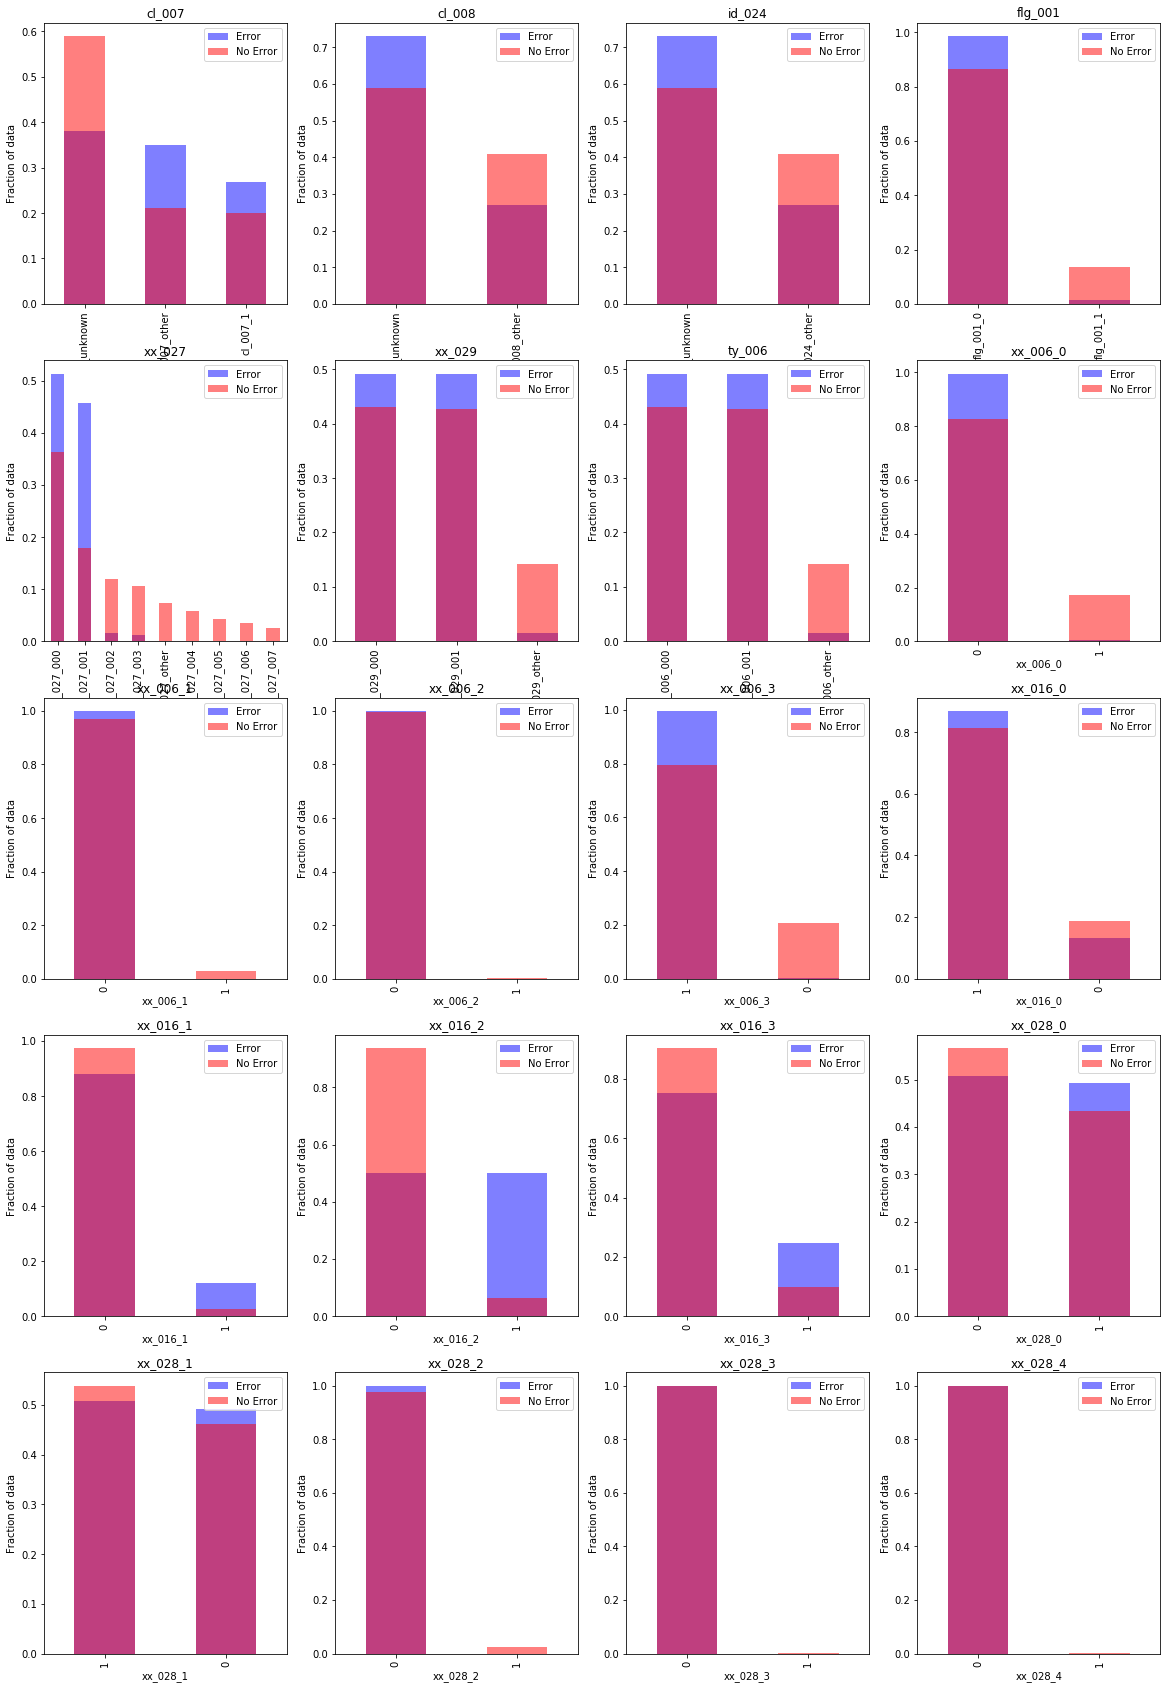

In [128]:
k=1
plt.figure(figsize=(20,30))
for v in df_combo.columns[25:]:
    plt.subplot(5,4,k)
    if len(df_combo[v].unique())>10:
        continue
    elif v == 'error':
        continue
    tab =df_combo.groupby('error')[v].value_counts(normalize=True)
    tab[1].plot(kind='bar', alpha=0.5,color='blue',label='Error')
    tab[0].plot(kind='bar', alpha=0.5,color='r',label='No Error')
    plt.legend()
    plt.ylabel('Fraction of data')
    plt.title(v)
    k+=1
    if k>20:
        print(np.where(df_combo.columns==v)[0])
        break 
plt.show()

Again, there are a number of categories, for which the error is more polarized but not for all. The clusters are apparently very scarce in their representation.

Interestingly, the categories that seem to be more polarized in respect to the error, are the ones that could not be used for the chi-squared test.

### Investigate the time feature

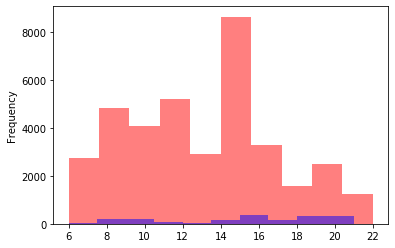

In [146]:
df_combo.loc[df_combo['error']==0,'dt_001'].map(lambda d: d.hour).plot(kind='hist',alpha=0.5,color='red')
df_combo.loc[df_combo['error']==1,'dt_001'].map(lambda d: d.hour).plot(kind='hist',alpha=0.5,color='blue')

In [10]:
df_time=pd.DataFrame(df_combo['error'].copy(),columns=['error'])
df_time['month']=[x.month for x in df_combo['dt_001']]
df_time['day']=[x.day for x in df_combo['dt_001']]
df_time['hour']=[x.hour for x in df_combo['dt_001']]
df_time['weekday']=[x.weekday() for x in df_combo['dt_001']]


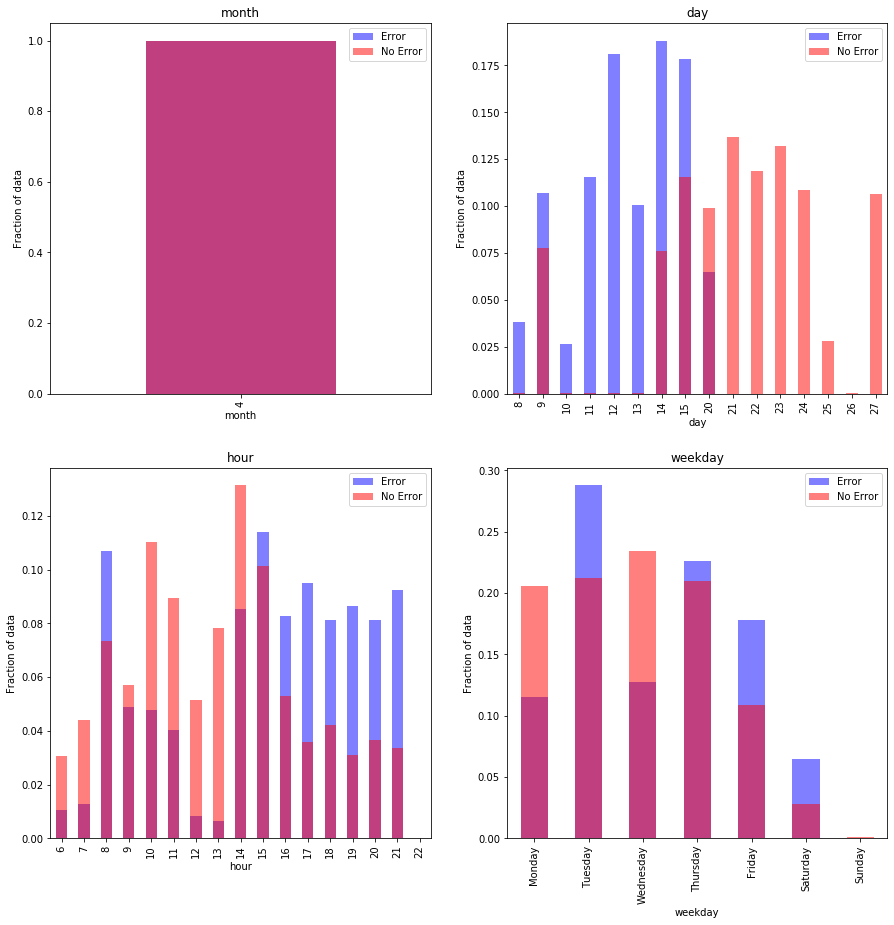

In [232]:
colors=['red','blue']
labels=['No Error','Error']
k=1
plt.figure(figsize=(15,15))
for v in df_time.columns[1:]:
    plt.subplot(2,2,k)
    tab =df_time.groupby('error')[v].value_counts(normalize=True)

    for i in np.arange(1,-1,-1):
        bla=tab[i].iloc[np.argsort(tab[i].index)]
        bla.plot(kind='bar', alpha=0.5,color=colors[i],label=labels[i])
    if v == 'weekday':
        plt.gca().set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    
    plt.legend()
    plt.ylabel('Fraction of data')
    plt.title(v)
    k+=1
    if k == 21:
        print(np.where(df_combo.columns==v)[0])
        break


It is interesting to see that errors happen rather **at the beginning of the month**, **aroud 8am or later in the day**, and rather **on Tuesday or towards the end of the week**.

Since we have only one month, we will take only the daytime and weekday as representative.

In [11]:
df_dum['morning'] = [0 if x >= 12 else 1 for x in df_time['hour']]
df_dum['afternoon'] = [0 if (x < 12)|(x>18) else 1 for x in df_time['hour']]
df_dum['evening'] = [0 if (x <= 18) else 1 for x in df_time['hour']]

In [12]:
wdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for i in range(7):
    df_dum[wdays[i]] = [1 if x == i else 0 for x in df_time['weekday']]

### Save data to table

In [13]:
con = sqlite3.connect('../data/data2.db')
df_dum.to_sql(name='data_dummies',con=con,if_exists='replace')
con.close()